# The Convolutional Classifier
## Introduction
> 목표: 사람이 시각적으로 봄으로써 해결할 수 있는 문제들을 어떻게 뉴럴 네트워크가 이미지 데이터를 가지고 해결할 수 있는지
- 해당 문제를 해결하기 위해 가장 적합한 방식: **Convolutional Neural Networks** (convnet 또는 CNN이라고 부름)
    - **Convolution**: 해당 레이어가 가지고 있는 독창적인 구조를 이용한 수학적 연산
- 위의 것을 가지고 이미지 분류 문제를 해결할 수 있음
- 여기서 이미지 분류란 주어진 사진을 보고 컴퓨터가 해당 사진이 어떤사진인지를 학습시키는 것임

## The Convolutional Classifier
- Convnet은 이미지 분류를 위해 **convolutional base** 그리고 **dense head** 두가지의 파트로 나누어진다.

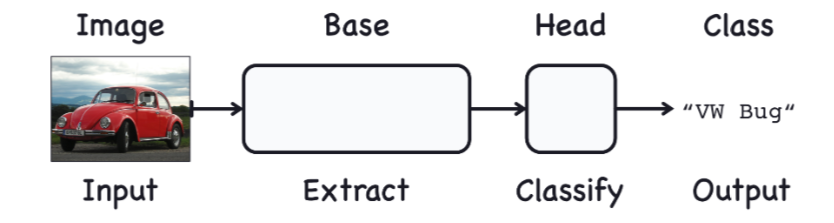

- **Convolutional Base**
    - 이미지로부터 특징을 추출해주는 역할
    - convolution operation을 수행하는 레이어로 구성
    - 하지만 종종 다른 종류의 레이어도 포함
- **Dense Head**
    - 이미지의 클래스를 결정하는 역할
    - 주로 dense layer로 이루어져있고, droupout과 같은 다른 레이어도 포함하고 있는 경우도 존재함

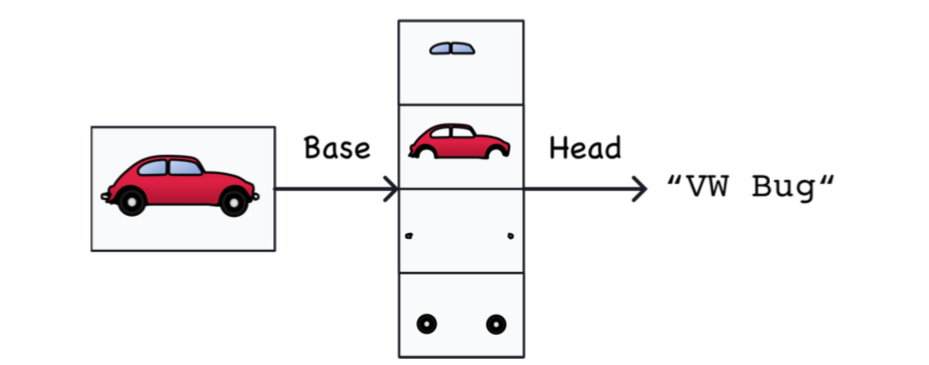

## Training the Classifier
- 트레이닝 시의 네트워크의 목적은 아래와 같다.
    - 어떤 특성을 이미지에서 추출할 것인지 (base)
    - 어떤 특성으로 클래스를 결정할 것인지 (head)

- convnet의 경우 **미리 트레이닝된 모델의 base를 재사용**
- 그리고 미리 트레이닝 된 base에 **트레이닝되지 않은 head를 붙힘.**
- 즉, **특징 추출을 학습한 네트워크의 일부를 사용하고 분류를 위해 새로운 여러 레이어를 덧붙힘.**
- head는 몇 개의 dense layer로 구성되어 있기 때문에, 상대적으로 적은 데이터로부터 정확한 분류기를 만들 수 있음.
- 미리 트레이닝 된 모델을 사용하는 것은 transfer learning이라고 하고, 매우 효과적이라서 요즘 거의 모든 이미지 분류기에서 사용됨.

## Train a Convnet Classifier
### 1, Load Data

In [2]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed(31415)

In [3]:
# 데이터 불러오기
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yeeunheo","key":"0f017459d5c97d28941064c3d5d7616d"}'}

In [5]:
# json 파일 ~/.kaggle로 이동
!mkdir -p ~/.kaggle
# Permission Warning 방지
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [10]:
# 데이터셋 다운 받기
!kaggle datasets download -d ryanholbrook/car-or-truck

 81% 63.0M/77.7M [00:00<00:00, 186MB/s]
100% 77.7M/77.7M [00:00<00:00, 165MB/s]


In [12]:
# 압축 해제
!unzip -qq '/content/car-or-truck.zip'

In [13]:
# matplotlib 설정
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings('ignore') # 출력 cell 비우기

In [14]:
# training, validation set 업로드
ds_train_ = image_dataset_from_directory(
    '/content/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

ds_valid_ = image_dataset_from_directory(
    '/content/valid',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64, # 몇 개의 샘플로 가중치를 갱신시킬 것인지
    shuffle=False,
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [15]:
# 데이터 파이프라인
def convert_to_float(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [17]:
import matplotlib.pyplot as plt

### 2. Define Pretrained Base

In [18]:
!kaggle datasets download -d ryanholbrook/cv-course-models

100% 479M/481M [00:03<00:00, 130MB/s]
100% 481M/481M [00:03<00:00, 137MB/s]


In [20]:
!unzip cv-course-models.zip

Archive:  cv-course-models.zip
  inflating: cv-course-models/.ipynb_checkpoints/encyclopedia-of-course-models-checkpoint.ipynb  
  inflating: cv-course-models/.ipynb_checkpoints/inceptionv1-checkpoint.ipynb  
  inflating: cv-course-models/.ipynb_checkpoints/inceptionv1-checkpoint.md  
  inflating: cv-course-models/.ipynb_checkpoints/minivgg-bn-checkpoint.ipynb  
  inflating: cv-course-models/.ipynb_checkpoints/minivgg-bn-checkpoint.md  
  inflating: cv-course-models/.ipynb_checkpoints/minivgg-checkpoint.ipynb  
  inflating: cv-course-models/.ipynb_checkpoints/minivgg-checkpoint.md  
  inflating: cv-course-models/.ipynb_checkpoints/simple-cnn-bn-checkpoint.ipynb  
  inflating: cv-course-models/.ipynb_checkpoints/simple-cnn-bn-checkpoint.md  
  inflating: cv-course-models/.ipynb_checkpoints/simple-cnn-checkpoint.ipynb  
  inflating: cv-course-models/.ipynb_checkpoints/simple-cnn-checkpoint.md  
  inflating: cv-course-models/.ipynb_checkpoints/vgg16-checkpoint.ipynb  
  inflating: cv-cour

In [21]:
pretrained_base = tf.keras.models.load_model(
    '/content/cv-course-models/vgg16-pretrained-base',
)

pretrained_base.trainable = False

### 3. Attach Head

In [22]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
  pretrained_base,
  layers.Flatten(), # base의 2차원 outputdmf 1차원 input으로 변환
  layers.Dense(6, activation='relu'), # output을 확률 스코어로 변환
  layers.Dense(1, activation='sigmoid')
])

### 4. Train

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', # 교차 엔트로피 (P에 대한 확률분포 Q가 존재할 때, Q와 P가 얼마나 비슷한지)
    metrics=['binary_accuracy'],
)

history = model.fit( # kerasdptj aksems ahepfdmf gkrtmq
    ds_train,
    validation_data = ds_valid,
    epochs=30, # 딥러닝 학습 횟수
    verbose=0, # 상세 로깅을 출력할지 말지 조정하는 parameter
)

In [ ]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()